<a href="https://colab.research.google.com/github/micole66/ai--photo/blob/main/ranking2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install open_clip_torch
!pip install matplotlib

import torch
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32B_b79k')
tokenizer = open_clip.get_tokenizer('ViT-H-14')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


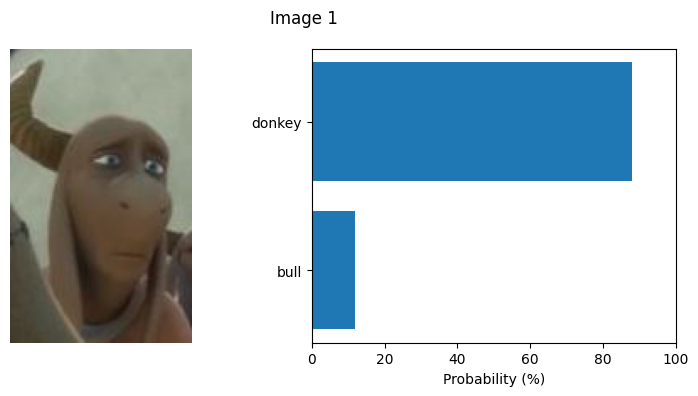

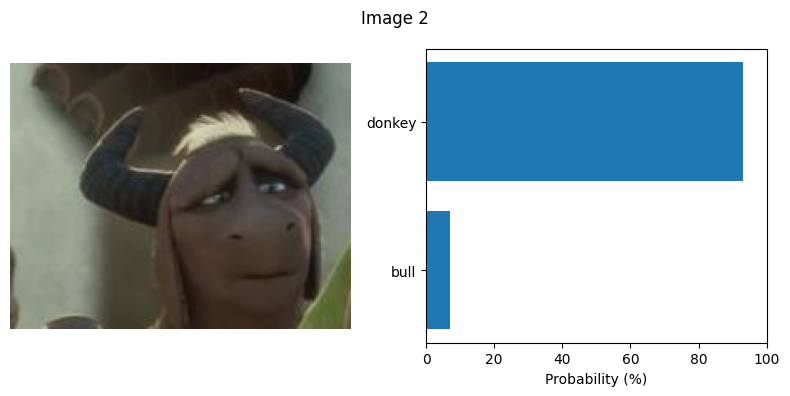

In [3]:
def rank_images(image_paths, custom_classes):
    images = [preprocess(Image.open(path)).unsqueeze(0) for path in image_paths]
    images = torch.cat(images, dim=0)
    text = tokenizer(custom_classes)

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    text_probs_percent = torch.round(text_probs * 100).tolist()

    for i, (image_path, row) in enumerate(zip(image_paths, text_probs_percent)):
        image = Image.open(image_path)
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.barh(custom_classes, row)
        plt.xlabel("Probability (%)")
        plt.xlim(0, 100)

        plt.suptitle(f"Image {i+1}")
        plt.tight_layout()
        plt.show()

image_paths = ["image1.jpg", "image2.jpg"]
custom_classes = ["bull", "donkey"]

rank_images(image_paths, custom_classes)